In [1]:
%matplotlib inline
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from astropy.table import Table, vstack
from astropy import units
import numpy as np
import matplotlib
import matplotlib.pylab as plt

#visits = [181898, 182014, 193861, 219976, 405724, 417009, 417057, 436500, 452564, 452599, 456722]
visits = [230, 192896, 202440, 204387, 211950, 214315, 216748, 225457]
filt = 'r'

bigCat = Table.read('src_catalog_2.fits')

In [34]:
%matplotlib inline
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from astropy.table import Table, vstack
from astropy import units
import numpy as np
import matplotlib
import matplotlib.pylab as plt


visits = [230, 192896, 202440, 204387, 211950, 214315, 216748, 225457]
#visits = [219976, 405724]
#tracts = [4429,  4431,  4433,  4637,  4639,  4848,  4850,  4852,  5063,  5065,
#          4430,  4432,  4636,  4638,  4640,  4849,  4851,  5062,  5064,  5066]

#Fix the track number for the moment
tract = 5063
filt = 'r'
butler = dafPersist.Butler("/sps/lsst/users/lsstprod/desc/DC2-test/newCam/input/rerun/jointcal3")

#fluxType = "base_PsfFlux"
fluxType = "slot_ModelFlux"
#fluxType = "base_CircularApertureFlux_6_0"

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         fluxType + "_flag", "base_SdssCentroid_flag", 
         "base_SdssCentroid_flag_almostNoSecondDerivative", "base_SdssCentroid_flag_edge", "base_SdssCentroid_flag_noSecondDerivative",
         "base_SdssCentroid_flag_notAtMaximum", "base_SdssCentroid_flag_resetToPeak", 
         "base_SdssShape_flag", "base_ClassificationExtendedness_flag"]

In [35]:
catList = []
for visit in visits:
    print('Reading visit:', visit)
    for count,data_ref in enumerate(butler.subset('src', visit=visit)):
        if data_ref.datasetExists():
            dataId = data_ref.dataId
        else:
            continue
        dataId['tract'] = tract
        if butler.datasetExists('jointcal_wcs', dataId) == False:
            continue
        if count%10 == 0 :
            print(count, dataId)
        src = butler.get('src', dataId, immediate=True, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
        v = src.asAstropy()
        
        # Get new photometry calibration
        newPhotocal = butler.get('jointcal_photoCalib', dataId, immediate=True)
        newMag = newPhotocal.instFluxToMagnitude(src, fluxType)
        v['newMag'] = newMag[:,0]
        v['newMagErr'] = newMag[:,1]

        # select sources
        cut = np.ones_like(v['id'], dtype=bool)
        for flag in Flags:
            cut &= v[flag]==False
        cut &= (v[fluxType + '_flux'] > 0) & (v[fluxType + '_flux'] / v[fluxType + '_fluxErr'] > 5)
        cut &= v['base_ClassificationExtendedness_value'] < 0.5

        # get calibration object and then magnitudes with errors
        calib = butler.get("calexp_calib", dataId, immediate=True)
        mag, magErr = calib.getMagnitude(v[cut][fluxType + '_flux'], v[cut][fluxType + '_fluxErr'])

        cat = v[cut]['id', 'coord_ra', 'coord_dec', fluxType + '_flux', 'newMag', 'newMagErr']
        cat['mag'] = mag
        cat['magErr'] = magErr

        # add dataId info
        for k in dataId.keys():
            cat[k] = dataId[k]
            
        # Get WCS info from calexp_wcs and from jointcal_wcs
        oldWcs = butler.get("calexp_wcs", dataId, immediate=True)
        newWcs = butler.get('jointcal_wcs', dataId, immediate=True)
        
        newRa = []
        newDec = []
        pixels = oldWcs.skyToPixel([afwGeom.SpherePoint(ra, dec, afwGeom.radians) for ra, dec in zip(cat['coord_ra'], cat['coord_dec'])])
        newCoord = newWcs.pixelToSky(pixels)                                       
#        for c in cat:
#            pixels = oldWcs.skyToPixel(afwGeom.SpherePoint(c['coord_ra'], c['coord_dec'], afwGeom.radians))
#            newRa.append(float((newWcs.pixelToSky(pixels).getRa())))
#            newDec.append(float((newWcs.pixelToSky(pixels).getDec())))
        cat['newRa'] = [float(cd.getRa()) for cd in newCoord]
        cat['newDec'] = [float(cd.getDec()) for cd in newCoord]
        cat['newRa'].unit = units.rad
        cat['newDec'].unit = units.rad

        # hack to get rid of a warning related to a merging conflict
        cat.meta['NOISE_EXPOSURE_ID'] = 0
         
        # add catalog to the list    
        catList.append(cat)
        
# merge all individual catalogs into a single big one    
bigCat = vstack(catList)


Reading visit: 230
0 {'visit': 230, 'filter': 'r', 'raftName': 'R12', 'detectorName': 'S22', 'detector': 53, 'tract': 5063}


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2018_36/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


10 {'visit': 230, 'filter': 'r', 'raftName': 'R14', 'detectorName': 'S10', 'detector': 66, 'tract': 5063}
20 {'visit': 230, 'filter': 'r', 'raftName': 'R22', 'detectorName': 'S02', 'detector': 92, 'tract': 5063}
30 {'visit': 230, 'filter': 'r', 'raftName': 'R23', 'detectorName': 'S10', 'detector': 102, 'tract': 5063}
40 {'visit': 230, 'filter': 'r', 'raftName': 'R24', 'detectorName': 'S11', 'detector': 112, 'tract': 5063}
50 {'visit': 230, 'filter': 'r', 'raftName': 'R32', 'detectorName': 'S02', 'detector': 137, 'tract': 5063}
60 {'visit': 230, 'filter': 'r', 'raftName': 'R33', 'detectorName': 'S10', 'detector': 147, 'tract': 5063}
70 {'visit': 230, 'filter': 'r', 'raftName': 'R34', 'detectorName': 'S11', 'detector': 157, 'tract': 5063}
80 {'visit': 230, 'filter': 'r', 'raftName': 'R42', 'detectorName': 'S22', 'detector': 179, 'tract': 5063}
Reading visit: 192896
0 {'visit': 192896, 'filter': 'r', 'raftName': 'R01', 'detectorName': 'S20', 'detector': 6, 'tract': 5063}
10 {'visit': 1928

In [ ]:
bigCat.write('src_catalog_2.fits')

In [3]:
bigCat

id,coord_ra,coord_dec,base_PsfFlux_flux,newMag,newMagErr,mag,magErr,visit,filter,raftName,detectorName,detector,tract,newRa,newDec
,rad,rad,ct,,,,,,,,,,,rad,rad
int64,float64,float64,float64,float64,float64,float64,float64,int64,str1,str3,str3,int64,int64,float64,float64
197796128882692,0.9355036129743509,-0.4715678133757099,7975.311117467869,21.648662827584428,0.02322013609550803,21.645560970069383,0.023220113620022867,230,r,R12,S22,53,5063,0.9355036889449212,-0.4715678177935966
197796128882694,0.9374239254608744,-0.47284417357631725,449200.9197542567,17.272606634034872,0.002484672790098375,17.268828462809186,0.0024844167798214385,230,r,R12,S22,53,5063,0.9374239381623868,-0.47284418635903497
197796128882697,0.9372854069239203,-0.47277772680932584,852.1424105375166,24.077405749740166,0.1894480558429897,24.0736496039178,0.18944805250514546,230,r,R12,S22,53,5063,0.9372854269343991,-0.47277773568630366
197796128882698,0.9375003139751525,-0.47292204258096676,4588.2931742294595,22.24953202060767,0.03791070269883379,22.245802155223437,0.037910686135999135,230,r,R12,S22,53,5063,0.9375003219355127,-0.4729220574290975
197796128882699,0.9371353819429917,-0.4726994488383389,391874.6637968996,17.420797404129576,0.0025270523169979857,17.417062090921068,0.0025268034658753567,230,r,R12,S22,53,5063,0.9371354069756852,-0.47269945486294895
197796128882701,0.9360405243201607,-0.47200870998018807,16647.363652979366,20.85002215466256,0.012718533989941811,20.846566388432116,0.012718488259903023,230,r,R12,S22,53,5063,0.936040544662535,-0.4720087106839491
197796128882703,0.9368481409529275,-0.4725401962502106,4166.156230848938,22.35427972360041,0.041205782014895644,22.35059117496916,0.041205766945905976,230,r,R12,S22,53,5063,0.936848168616198,-0.47254019935659264
197796128882706,0.9387390073581279,-0.4737749221680964,6669.848468022294,21.84292753408936,0.02683197547235224,21.839640136585913,0.026831954855336144,230,r,R12,S22,53,5063,0.9387388307801037,-0.4737750938248855


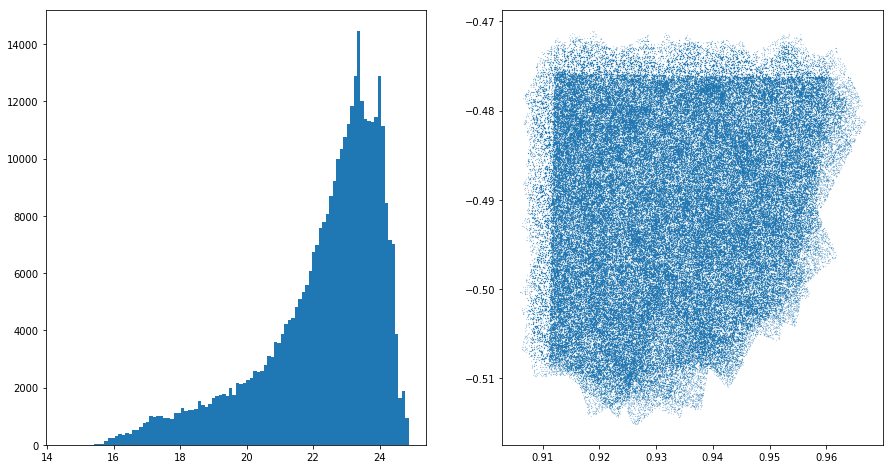

In [4]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax0.hist(bigCat['mag'], bins=100)
_ = ax1.scatter(bigCat['coord_ra'], bigCat['coord_dec'], s=0.01)

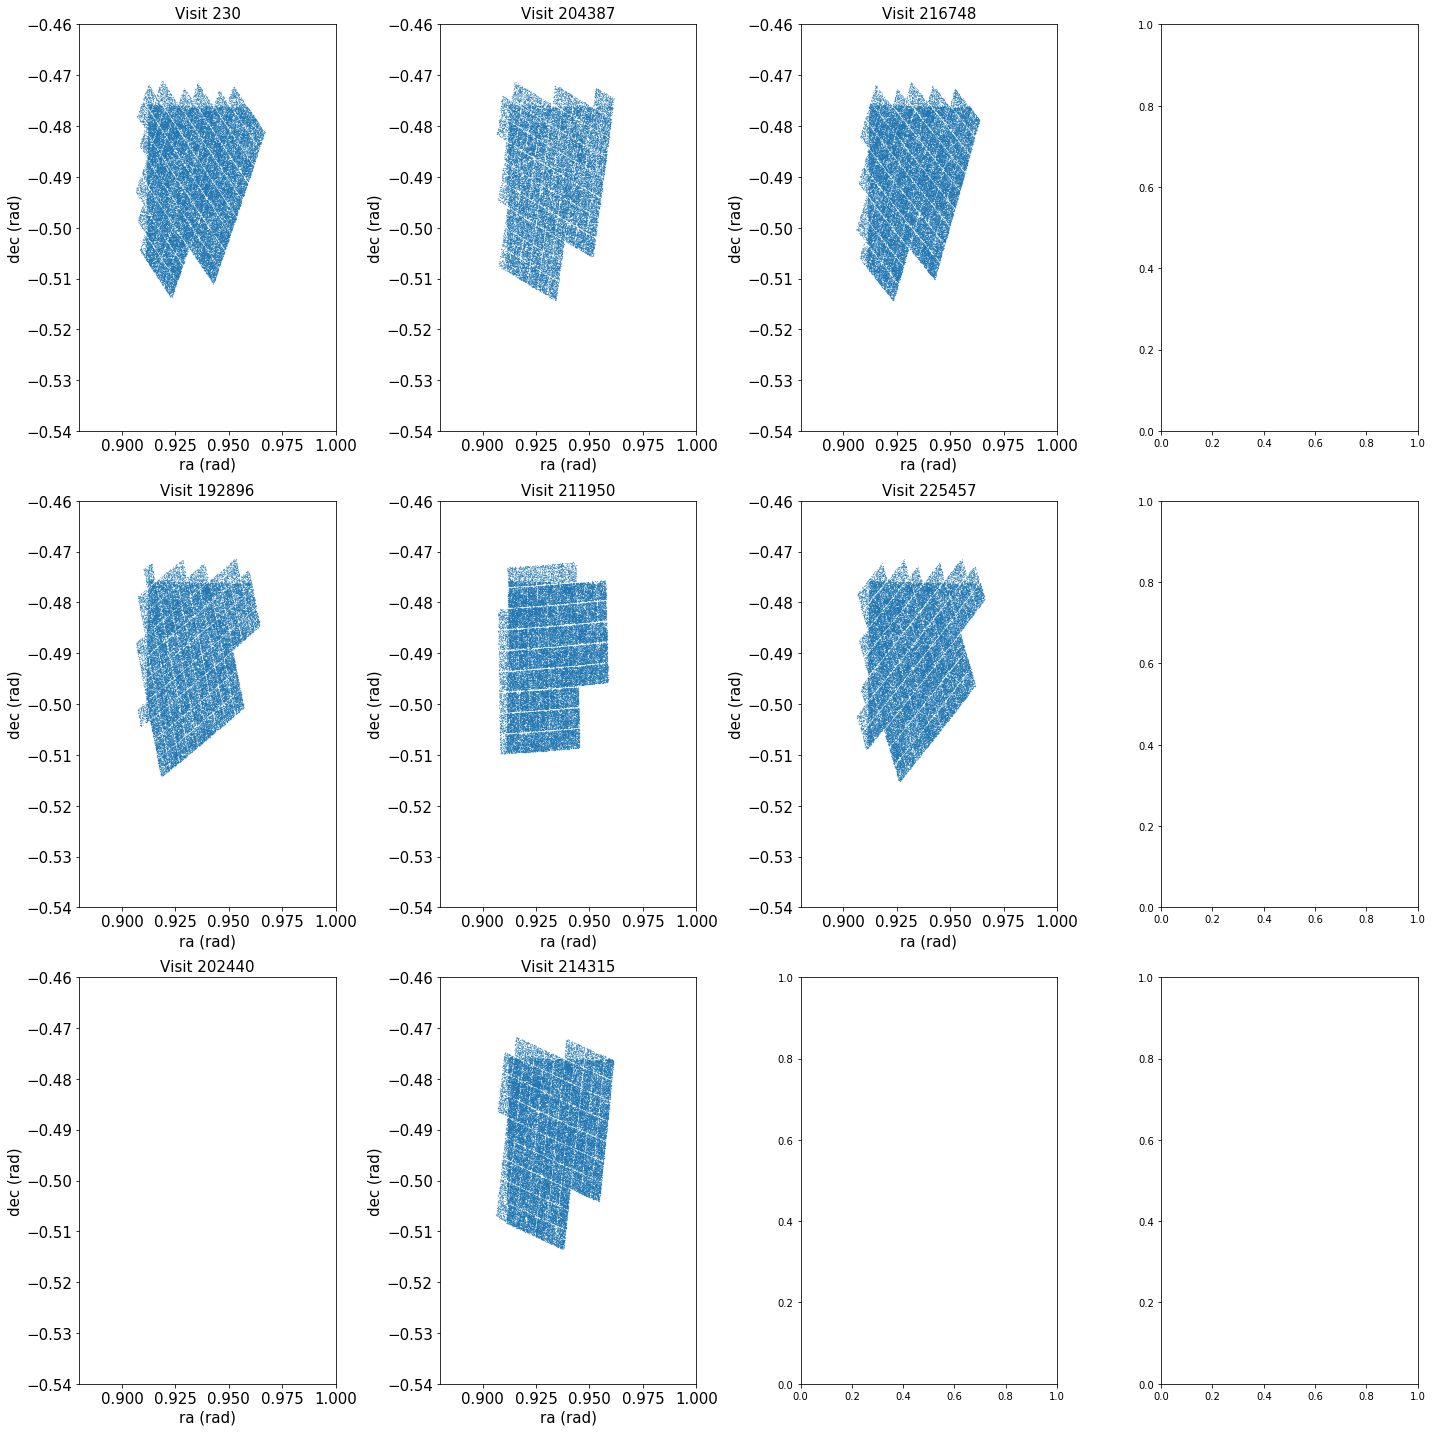

In [8]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(20,20))
for i,v in enumerate(visits):
    a = i%3
    b = i//3
    cut = bigCat['visit'] == v
    ax[a][b].scatter(bigCat[cut]['coord_ra'], bigCat[cut]['coord_dec'], s=0.02)
    ax[a][b].set_xlim([0.88,1.00])
    ax[a][b].set_ylim([-0.54, -0.46])
    ax[a][b].set_xlabel('ra (rad)', fontsize=15)
    ax[a][b].set_ylabel('dec (rad)', fontsize=15)
    ax[a][b].set_title('Visit %d'%(v), fontsize=15)
    ax[a][b].tick_params(labelsize=15)
    
fig.tight_layout()

In [42]:
#fig.savefig("ra_dec_r.png")

In [36]:
from astropy.coordinates import SkyCoord
from astropy import units as u

visits = [230, 192896, 202440, 204387, 211950, 214315, 216748, 225457]
vRef = 230
tract = 5063
cRef = SkyCoord(ra = bigCat[bigCat['visit']==vRef]['coord_ra'], dec = bigCat[bigCat['visit']==vRef]['coord_dec'])
cRefNew = SkyCoord(ra = bigCat[bigCat['visit']==vRef]['newRa'], dec = bigCat[bigCat['visit']==vRef]['newDec'])

bigCat['dist'] = 999999.

dist = []
distNew = []
dMag = []
dMagNew = []
for count,v in enumerate(visits):
    if v == vRef:
        dist = dist + [9999.]*sum(bigCat['visit']==vRef)
        distNew = distNew + [9999.]*sum(bigCat['visit']==vRef)
        dMag = dMag + [9999.]*sum(bigCat['visit']==vRef)
        dMagNew = dMagNew + [9999.]*sum(bigCat['visit']==vRef)
        continue
    
    c = SkyCoord(ra = bigCat[bigCat['visit']==v]['coord_ra'], dec = bigCat[bigCat['visit']==v]['coord_dec'])
    cNew = SkyCoord(ra = bigCat[bigCat['visit']==v]['newRa'], dec = bigCat[bigCat['visit']==v]['newDec'])
    idx, d2d, d3d = c.match_to_catalog_sky(cRef)
    idxNew, d2dNew, d3dNew = cNew.match_to_catalog_sky(cRefNew)
    
    dist = dist + d2d.milliarcsecond.tolist()
    distNew = distNew + d2dNew.milliarcsecond.tolist()
    
    dMag = dMag + (bigCat[bigCat['visit']==v]['mag'] - bigCat[bigCat['visit']==vRef]['mag'][idx]).tolist()
    dMagNew = dMagNew + (bigCat[bigCat['visit']==v]['newMag'] - bigCat[bigCat['visit']==vRef]['newMag'][idxNew]).tolist()
    
bigCat['dist'] = dist
bigCat['distNew'] = distNew
bigCat['dMag'] = dMag
bigCat['dMagNew'] = dMagNew

In [ ]:
 bigCat[bigCat['visit']==v]['mag']  - bigCat[bigCat['visit']==vRef]['mag'][idx]

In [ ]:
dMag

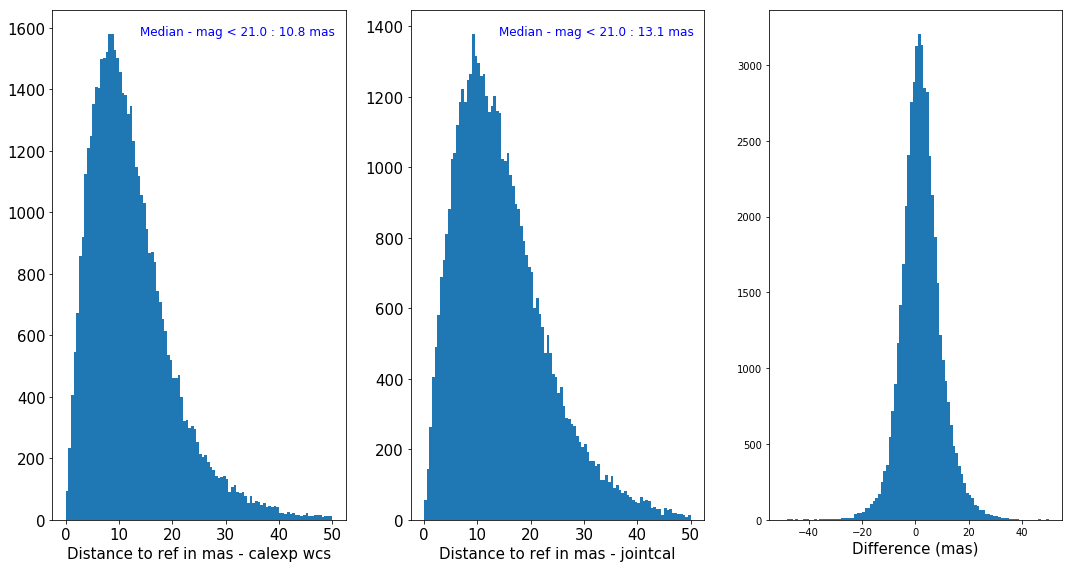

In [37]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 8))

magCut = 21
cut = (bigCat['dist'] < 300) & (bigCat['distNew'] < 300) & (bigCat['mag'] < magCut)
_ = ax0.hist(bigCat[cut]['dist'], bins=100, range = [0., 50])
_ = ax1.hist(bigCat[cut]['distNew'], bins=100, range = [0., 50])
_ = ax2.hist(bigCat[cut]['distNew'] - bigCat[cut]['dist'], bins=100, range=[-50, 50])

ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)
ax0.set_xlabel('Distance to ref in mas - calexp wcs', fontsize=15)
ax1.set_xlabel('Distance to ref in mas - jointcal', fontsize=15)
ax2.set_xlabel('Difference (mas)', fontsize=15)

ax0.annotate("Median - mag < %0.1f : %0.1f mas"%(magCut, np.median(bigCat[cut]['dist'])),
             fontsize=12, color='b', xy=(0.3, 0.95), xycoords='axes fraction')
ax1.annotate("Median - mag < %0.1f : %0.1f mas"%(magCut, np.median(bigCat[cut]['distNew'])),
             fontsize=12, color='b', xy=(0.3, 0.95), xycoords='axes fraction')
                                                         
fig.tight_layout()

In [8]:
fig.savefig("DC2_astrometry.png")

0.15012488941401614 -0.17696224049501552
19.9036545837381 19.856093204507772


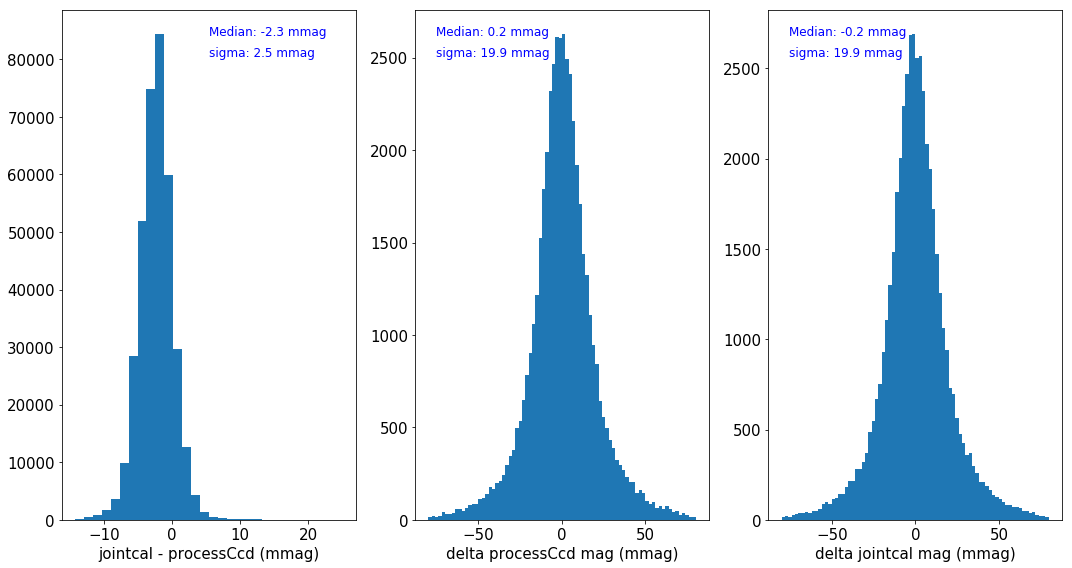

In [38]:
magCut = 21
cut = (bigCat['dMag'] < 0.08) & (bigCat['dMagNew'] < 0.08) & (bigCat['mag'] < magCut) & (bigCat['dMag'] > -0.08) & (bigCat['dMagNew'] > -0.08)
cut &= (bigCat['distNew'] < 50)

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 8))
_ = ax0.hist((bigCat['newMag'] - bigCat['mag'])*1000, bins=30)
_ = ax1.hist(bigCat[cut]['dMag']*1000, bins=80)
_ = ax2.hist(bigCat[cut]['dMagNew']*1000, bins=80)

ax0.set_xlabel('jointcal - processCcd (mmag)', fontsize=15)
ax1.set_xlabel('delta processCcd mag (mmag)', fontsize=15)
ax2.set_xlabel('delta jointcal mag (mmag)', fontsize=15)

ax0.annotate("Median: %0.1f mmag"%(np.median(bigCat['newMag'] - bigCat['mag'])*1000),
             fontsize=12, color='b', xy=(0.5, 0.95), xycoords='axes fraction')
ax0.annotate("sigma: %0.1f mmag"%(np.std(bigCat['newMag'] - bigCat['mag'])*1000),
             fontsize=12, color='b', xy=(0.5, 0.91), xycoords='axes fraction')
ax1.annotate("Median: %0.1f mmag"%(np.median(bigCat[cut]['dMag']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.95), xycoords='axes fraction')
ax1.annotate("sigma: %0.1f mmag"%(np.std(bigCat[cut]['dMag']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.91), xycoords='axes fraction')
ax2.annotate("Median: %0.1f mmag"%(np.median(bigCat[cut]['dMagNew']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.95), xycoords='axes fraction')
ax2.annotate("sigma: %0.1f mmag"%(np.std(bigCat[cut]['dMagNew']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.91), xycoords='axes fraction')


ax0.tick_params(labelsize=15)
ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)

fig.tight_layout()

print(np.median(bigCat[cut]['dMag']*1000), np.median(bigCat[cut]['dMagNew']*1000))
print(np.std(bigCat[cut]['dMag']*1000), np.std(bigCat[cut]['dMagNew']*1000))

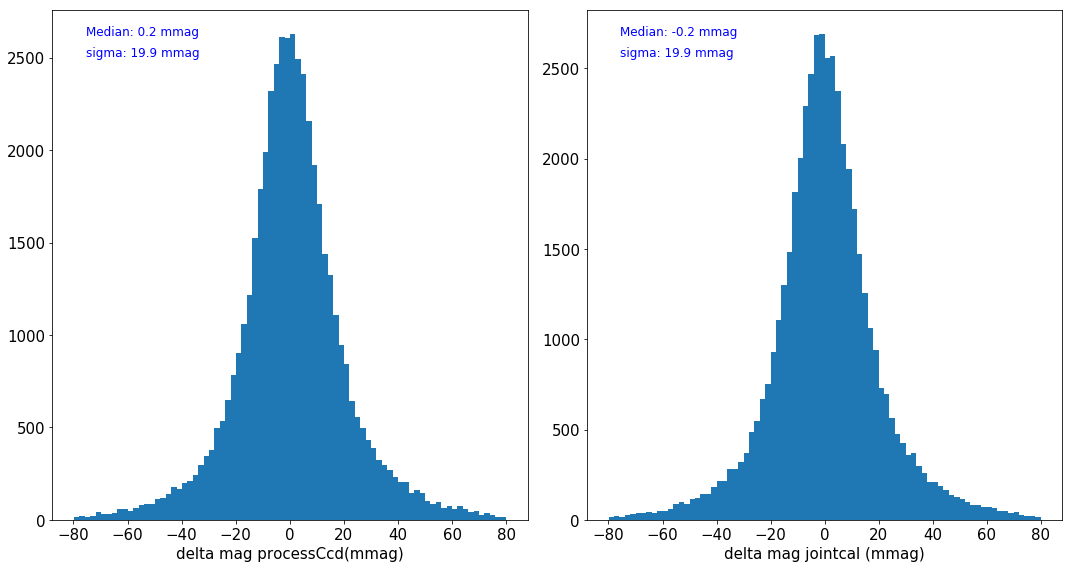

In [39]:
magCut = 21
cut = (bigCat['dMag'] < 0.08) & (bigCat['dMagNew'] < 0.08) & (bigCat['mag'] < magCut) & (bigCat['dMag'] > -0.08) & (bigCat['dMagNew'] > -0.08)
cut &= (bigCat['distNew'] < 50)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax1.hist(bigCat[cut]['dMag']*1000, bins=80)
_ = ax2.hist(bigCat[cut]['dMagNew']*1000, bins=80)

ax1.set_xlabel('delta mag processCcd(mmag)', fontsize=15)
ax2.set_xlabel('delta mag jointcal (mmag)', fontsize=15)

ax1.annotate("Median: %0.1f mmag"%(np.median(bigCat[cut]['dMag']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.95), xycoords='axes fraction')
ax1.annotate("sigma: %0.1f mmag"%(np.std(bigCat[cut]['dMag']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.91), xycoords='axes fraction')
ax2.annotate("Median: %0.1f mmag"%(np.median(bigCat[cut]['dMagNew']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.95), xycoords='axes fraction')
ax2.annotate("sigma: %0.1f mmag"%(np.std(bigCat[cut]['dMagNew']*1000)),
             fontsize=12, color='b', xy=(0.07, 0.91), xycoords='axes fraction')


ax1.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)

fig.tight_layout()

In [25]:
fig.savefig("DC2_photometry_constrained.png")

In [10]:
schema = src.getSchema()
schema.getOrderedNames()

['id',
 'coord_ra',
 'coord_dec',
 'parent',
 'calib_detected',
 'calib_psfCandidate',
 'calib_psfUsed',
 'calib_psf_reserved',
 'deblend_nChild',
 'deblend_deblendedAsPsf',
 'deblend_psfCenter_x',
 'deblend_psfCenter_y',
 'deblend_psfFlux',
 'deblend_tooManyPeaks',
 'deblend_parentTooBig',
 'deblend_masked',
 'deblend_skipped',
 'deblend_rampedTemplate',
 'deblend_patchedTemplate',
 'deblend_hasStrayFlux',
 'base_NaiveCentroid_x',
 'base_NaiveCentroid_y',
 'base_NaiveCentroid_flag',
 'base_NaiveCentroid_flag_noCounts',
 'base_NaiveCentroid_flag_edge',
 'base_NaiveCentroid_flag_resetToPeak',
 'base_SdssCentroid_x',
 'base_SdssCentroid_y',
 'base_SdssCentroid_xErr',
 'base_SdssCentroid_yErr',
 'base_SdssCentroid_flag',
 'base_SdssCentroid_flag_edge',
 'base_SdssCentroid_flag_noSecondDerivative',
 'base_SdssCentroid_flag_almostNoSecondDerivative',
 'base_SdssCentroid_flag_notAtMaximum',
 'base_SdssCentroid_flag_resetToPeak',
 'base_Blendedness_old',
 'base_Blendedness_raw_flux',
 'base_B

In [13]:
src[1].get('slot_ModelFlux_flux')

8217.66623058453